<a href="https://colab.research.google.com/github/SrinilayVelugoti/Melanoma-Detection-Assignment/blob/master/Copy_of_Starter_code_Assignment_CNN_Skin_Cancer_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Note : Clone the git repo before running the code as the training and testing images required for this are on git

In [1]:
!git clone https://github.com/SrinilayVelugoti/Melanoma-Detection-Assignment.git

Cloning into 'Melanoma-Detection-Assignment'...
remote: Enumerating objects: 2235, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 2235 (delta 3), reused 0 (delta 0), pack-reused 2226
Receiving objects: 100% (2235/2235), 765.38 MiB | 28.78 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (2361/2361), done.


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path(r"/content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path(r"/content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [5]:
def image_stats(_dir) :
    l = [(str(i),str(i).split('/')[-2]) for i in _dir.glob('*/*.jpg')]
    dir_paths = np.array(l)[:,0]
    val_counts = np.array(l)[:,1]
    df = pd.Series(val_counts).value_counts()
    df = df.reset_index()
    df.columns = ['class','count']
    df['percent'] = 100 * df['count'] / df['count'].sum()
    display(df)
    return dir_paths,df

In [6]:
dir_paths,tr_df = image_stats(data_dir_train)


class  count    percent
0  pigmented benign keratosis    462  20.634212
1                    melanoma    438  19.562305
2        basal cell carcinoma    376  16.793211
3                       nevus    357  15.944618
4     squamous cell carcinoma    181   8.083966
5             vascular lesion    139   6.208129
6           actinic keratosis    114   5.091559
7              dermatofibroma     95   4.242966
8        seborrheic keratosis     77   3.439035

In [7]:
test_path,ts_df = image_stats(data_dir_test)

class  count    percent
0                    melanoma     16  13.559322
1        basal cell carcinoma     16  13.559322
2           actinic keratosis     16  13.559322
3  pigmented benign keratosis     16  13.559322
4                       nevus     16  13.559322
5              dermatofibroma     16  13.559322
6     squamous cell carcinoma     16  13.559322
7             vascular lesion      3   2.542373
8        seborrheic keratosis      3   2.542373

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
# Creating the Test and Validation sets , 80% of data goes to training while the validation set has 20% of the data
# Each of the images are of size (180,180,3) -> 180 and 180 are height and width while 3 is the noof channels
train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='both',)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [11]:
# Preparing Sample images of each class
sample_class = {}
for j in dir_paths :
    class_holder = j.split('/')[-2]
    if sample_class :
        if class_holder in sample_class.keys() :
            continue
        sample_class[class_holder] = j
    sample_class[class_holder] = j

    if len(sample_class) == len(class_names) :
        break





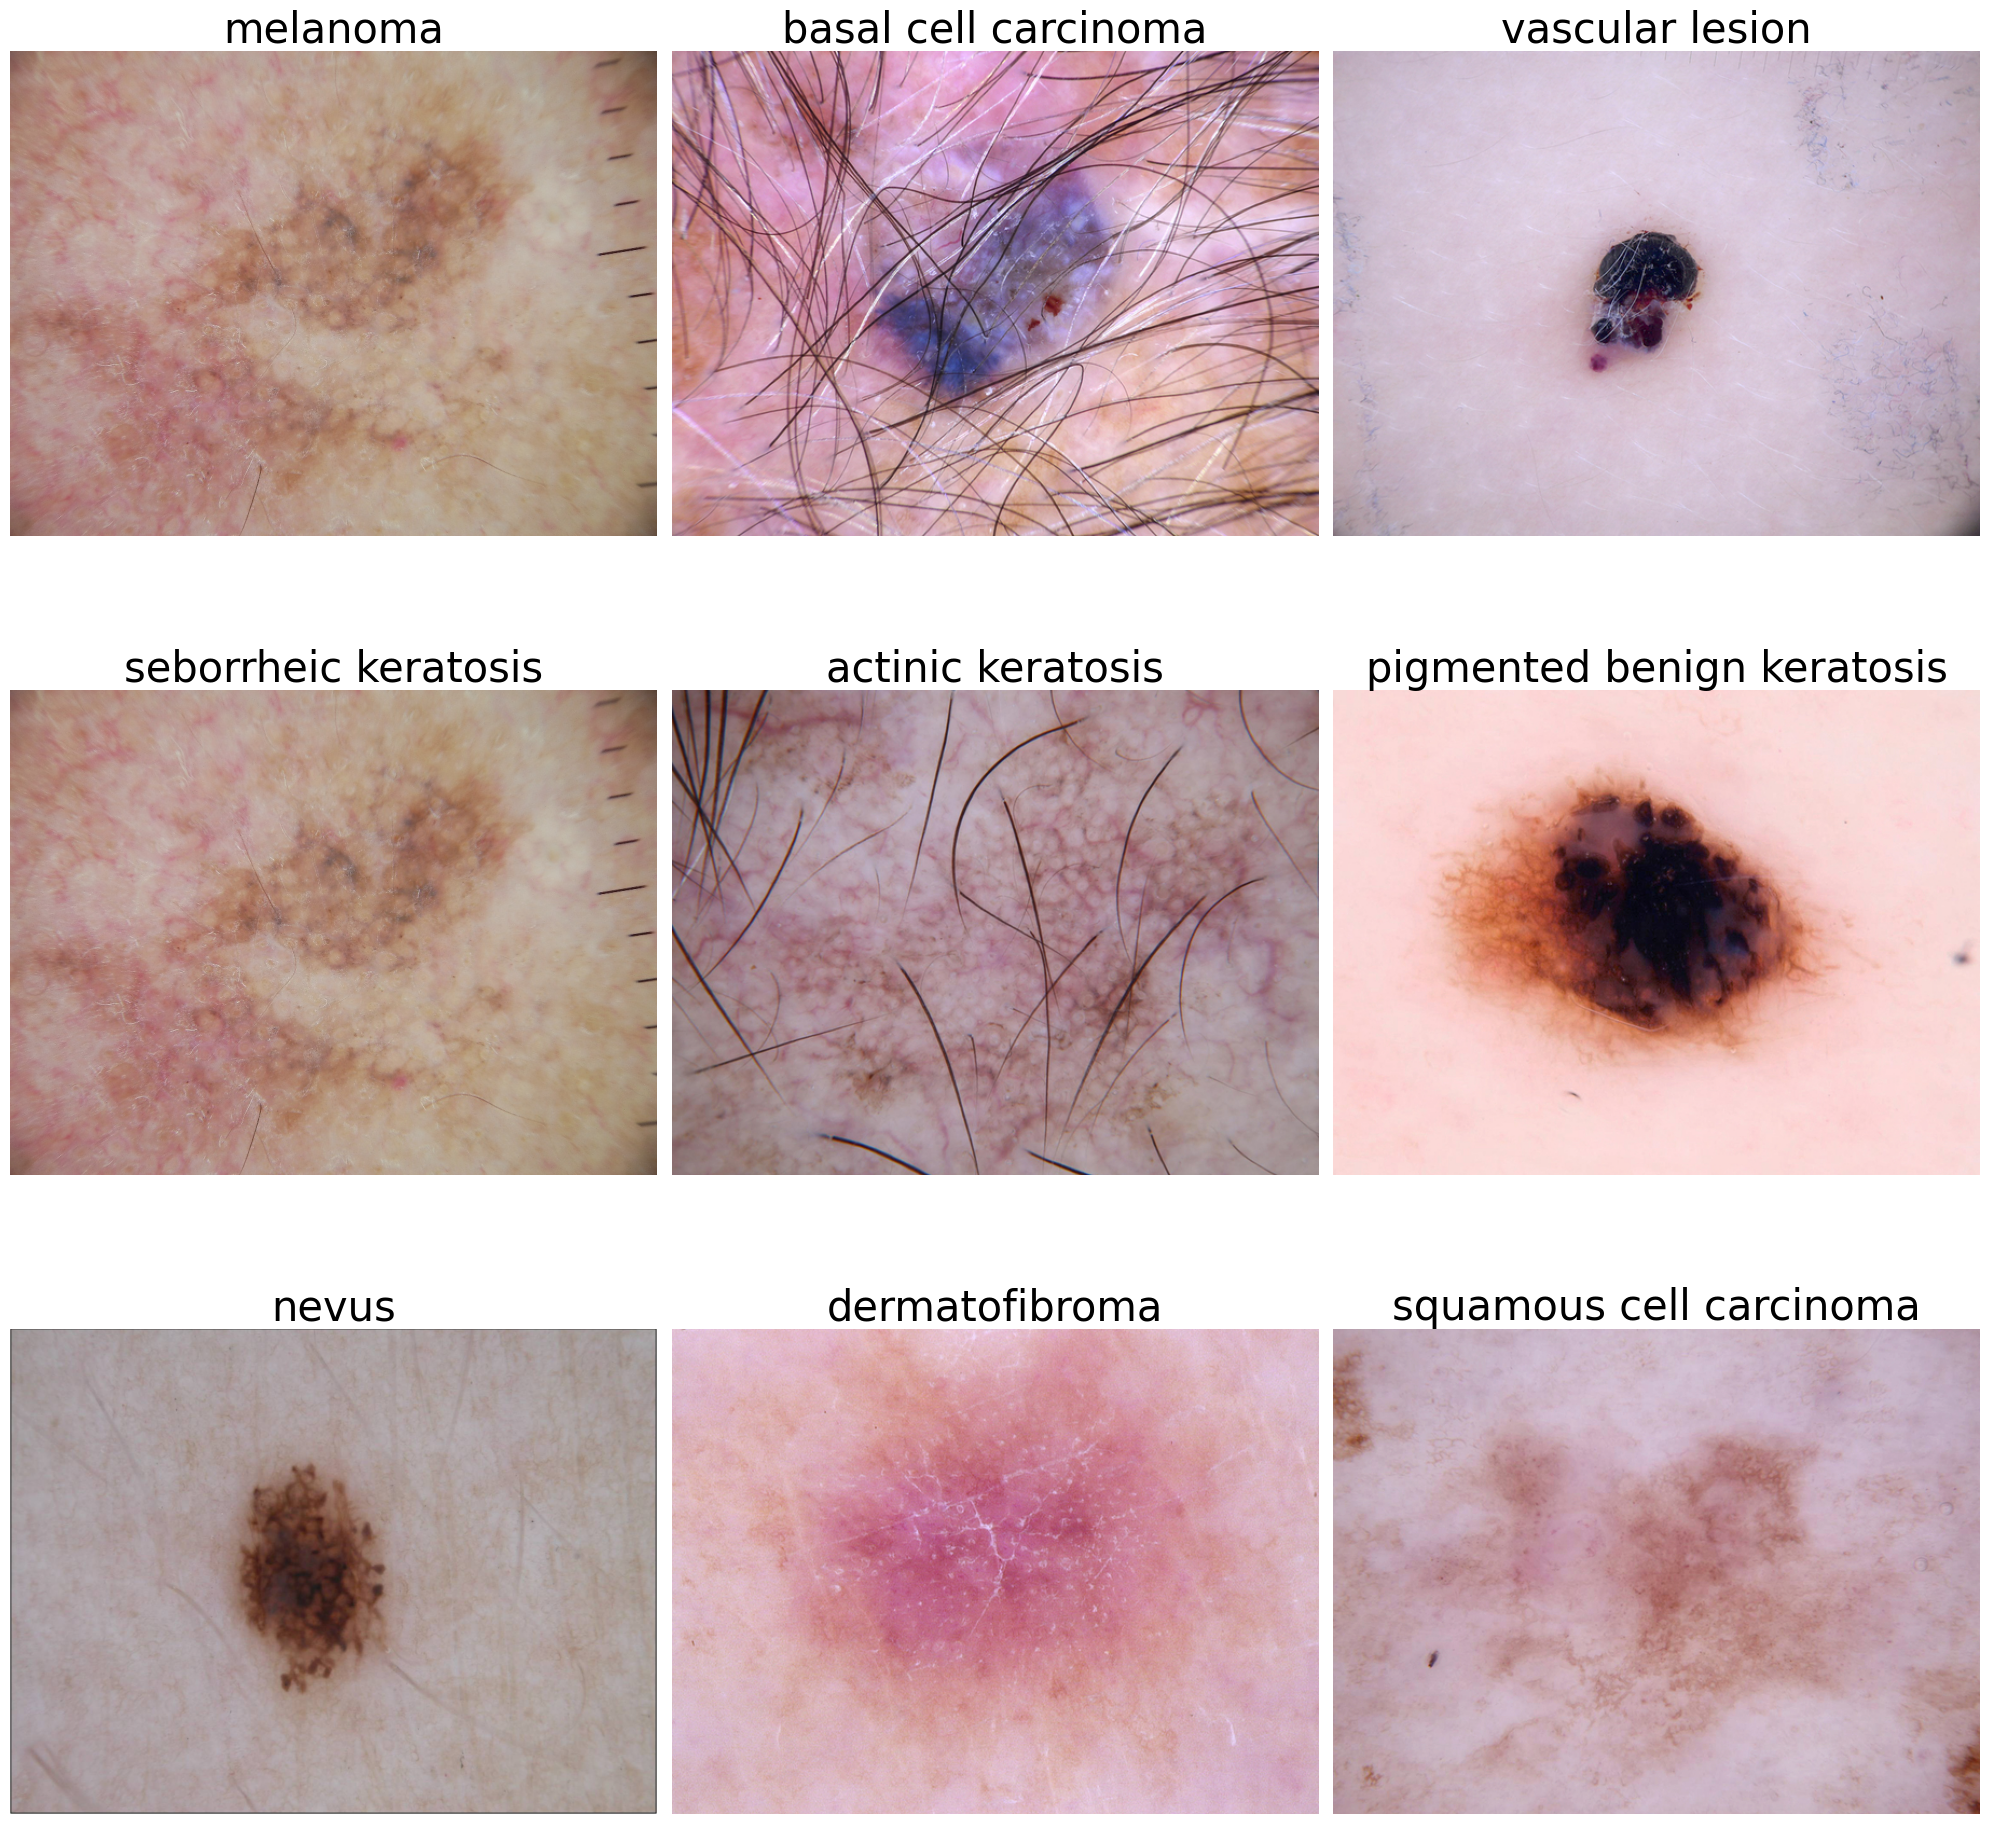

In [12]:
fig,ax = plt.subplots(3,3,figsize=(20,20))
for idx,(cat,val) in enumerate(sample_class.items()) :
    idx2 = idx % 3
    idx1 = idx // 3
    ax[idx1,idx2].imshow(PIL.Image.open(val))
    ax[idx1,idx2].axis('off')
    ax[idx1,idx2].set_title(cat,fontsize=30)
plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    # layers.Dropout(0.1),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.Dropout(0.25),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 64)        36928     
                                                        

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 25s 123ms/step - loss: 2.1804 - accuracy: 0.2031 - val_loss: 2.0272 - val_accuracy: 0.2282
Epoch 2/20
56/56 [==============================] - 4s 66ms/step - loss: 1.9292 - accuracy: 0.2550 - val_loss: 1.8404 - val_accuracy: 0.3087
Epoch 3/20
56/56 [==============================] - 4s 65ms/step - loss: 1.7351 - accuracy: 0.3661 - val_loss: 1.5014 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 4s 65ms/step - loss: 1.4701 - accuracy: 0.4805 - val_loss: 1.4770 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 4s 66ms/step - loss: 1.4388 - accuracy: 0.4978 - val_loss: 1.4865 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 4s 65ms/step - loss: 1.3184 - accuracy: 0.5352 - val_loss: 1.4508 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 4s 65ms/step - loss: 1.2583 - accuracy: 0.5608 - val_loss: 1.4191 - val_accuracy: 0.5123
Epoch 8/20


### Visualizing training results

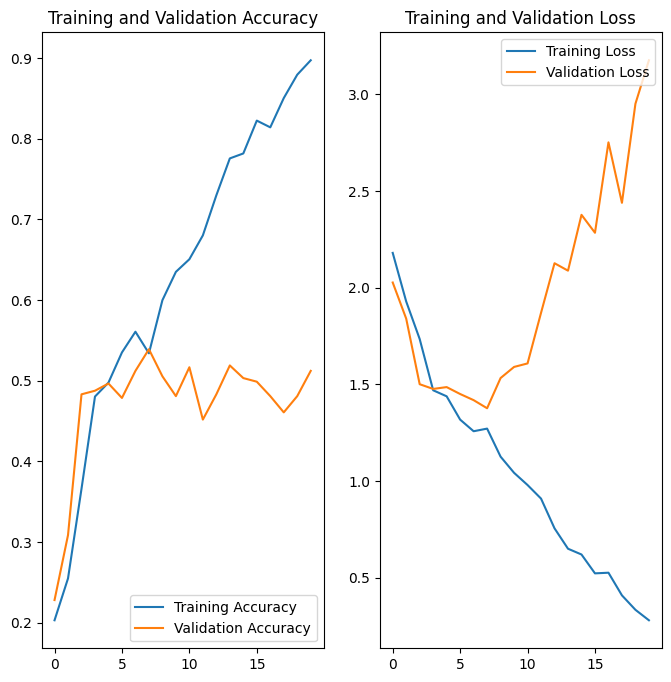

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Train the Same model this time with Dropouts and Batch Normalization

In [19]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 dropout (Dropout)           (None, 176, 176, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 176, 176, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                 

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 10s 122ms/step - loss: 9.9432 - accuracy: 0.2762 - val_loss: 2.2915 - val_accuracy: 0.1544
Epoch 2/20
56/56 [==============================] - 7s 118ms/step - loss: 2.2136 - accuracy: 0.2640 - val_loss: 2.1740 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 7s 119ms/step - loss: 2.0401 - accuracy: 0.3471 - val_loss: 5.2530 - val_accuracy: 0.1655
Epoch 4/20
56/56 [==============================] - 7s 120ms/step - loss: 1.8776 - accuracy: 0.3387 - val_loss: 14.3551 - val_accuracy: 0.1879
Epoch 5/20
56/56 [==============================] - 7s 121ms/step - loss: 1.8731 - accuracy: 0.3371 - val_loss: 6.4476 - val_accuracy: 0.2528
Epoch 6/20
56/56 [==============================] - 7s 120ms/step - loss: 1.7517 - accuracy: 0.3778 - val_loss: 6.8902 - val_accuracy: 0.2215
Epoch 7/20
56/56 [==============================] - 7s 119ms/step - loss: 1.6979 - accuracy: 0.3717 - val_loss: 9.5352 - val_accuracy: 0.3043
Epoc

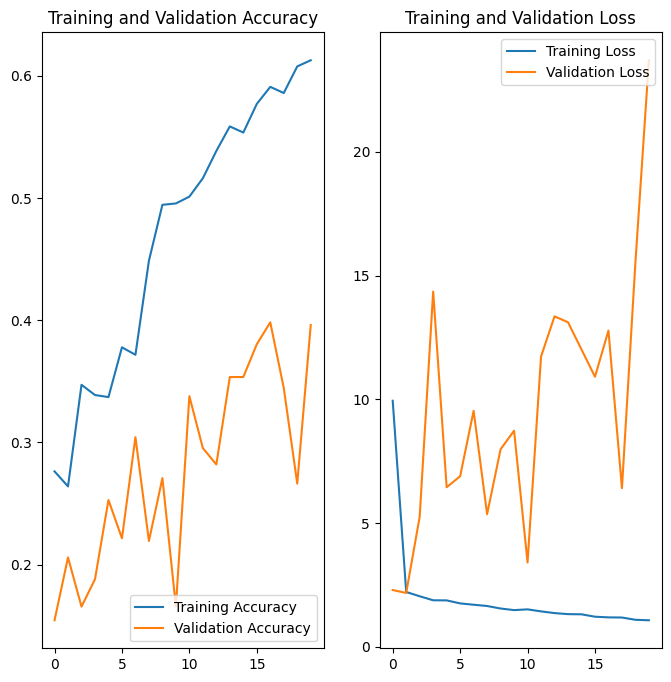

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### It can be clearly seen that the model has overfit . While the training accuracy shows clear signs of increasing , the testing accuracy very slowly.
### The same can be observed with loss too . While the Training Loss keeps moving down , the testing loss keeps increasing

# Augumentation using Image Data Generator

In [22]:
datagen = ImageDataGenerator(
        # rescale=1./255,
        rotation_range = 25,
        width_shift_range = .05,
        height_shift_range = .03,
        fill_mode = 'nearest',
        # vertical_flip=True,
        shear_range = 0.25,
        zoom_range = 0.2,
        horizontal_flip=True,
        validation_split = .2)

train_ds= datagen.flow_from_directory(
        data_dir_train,
        target_size=(img_height, img_width),
        batch_size=batch_size,
         subset='training',
        seed = 123,
        class_mode = 'categorical'
        )
val_ds = datagen.flow_from_directory(
        data_dir_train,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        subset='validation',
        seed = 123,
        class_mode = 'categorical'
)


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [23]:
train_ds.class_indices


{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

## Without Batch Normalization or Dropouts

In [24]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 86, 86, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 84, 84, 64)        36928     
                                                      

In [25]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 38s 636ms/step - loss: 2.2761 - accuracy: 0.2295 - val_loss: 1.9458 - val_accuracy: 0.3266
Epoch 2/20
57/57 [==============================] - 35s 612ms/step - loss: 1.7283 - accuracy: 0.4156 - val_loss: 1.8222 - val_accuracy: 0.4077
Epoch 3/20
57/57 [==============================] - 33s 587ms/step - loss: 1.4955 - accuracy: 0.4942 - val_loss: 2.2657 - val_accuracy: 0.4662
Epoch 4/20
57/57 [==============================] - 35s 611ms/step - loss: 1.4527 - accuracy: 0.4981 - val_loss: 1.9795 - val_accuracy: 0.3266
Epoch 5/20
57/57 [==============================] - 37s 653ms/step - loss: 1.4369 - accuracy: 0.5058 - val_loss: 1.9473 - val_accuracy: 0.4572
Epoch 6/20
57/57 [==============================] - 34s 600ms/step - loss: 1.3679 - accuracy: 0.5192 - val_loss: 1.8046 - val_accuracy: 0.4302
Epoch 7/20
57/57 [==============================] - 35s 614ms/step - loss: 1.3561 - accuracy: 0.5226 - val_loss: 1.9103 - val_accuracy: 0.4437

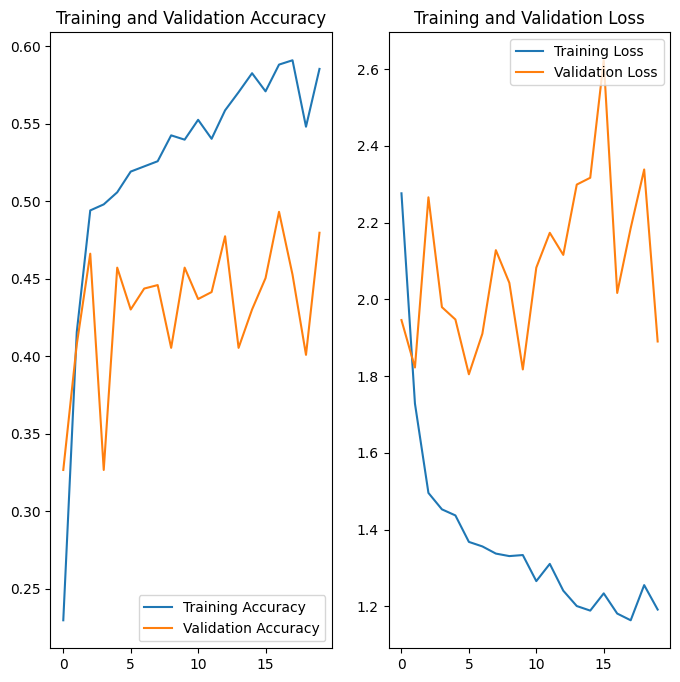

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## With Batch Normalization or Dropouts

In [27]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_2 (Bat  (None, 176, 176, 32)      128       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 176, 176, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                 

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 37s 605ms/step - loss: 11.2230 - accuracy: 0.2652 - val_loss: 27.5882 - val_accuracy: 0.1914
Epoch 2/20
57/57 [==============================] - 34s 599ms/step - loss: 2.1603 - accuracy: 0.2657 - val_loss: 58.2114 - val_accuracy: 0.2072
Epoch 3/20
57/57 [==============================] - 35s 614ms/step - loss: 1.9972 - accuracy: 0.3532 - val_loss: 53.0523 - val_accuracy: 0.2050
Epoch 4/20
57/57 [==============================] - 36s 625ms/step - loss: 1.9401 - accuracy: 0.3766 - val_loss: 52.8075 - val_accuracy: 0.2455
Epoch 5/20
57/57 [==============================] - 36s 631ms/step - loss: 1.8613 - accuracy: 0.3961 - val_loss: 34.9820 - val_accuracy: 0.2027
Epoch 6/20
57/57 [==============================] - 35s 617ms/step - loss: 1.8292 - accuracy: 0.3749 - val_loss: 32.8373 - val_accuracy: 0.2275
Epoch 7/20
57/57 [==============================] - 34s 603ms/step - loss: 1.8560 - accuracy: 0.3716 - val_loss: 26.3915 - val_accuracy

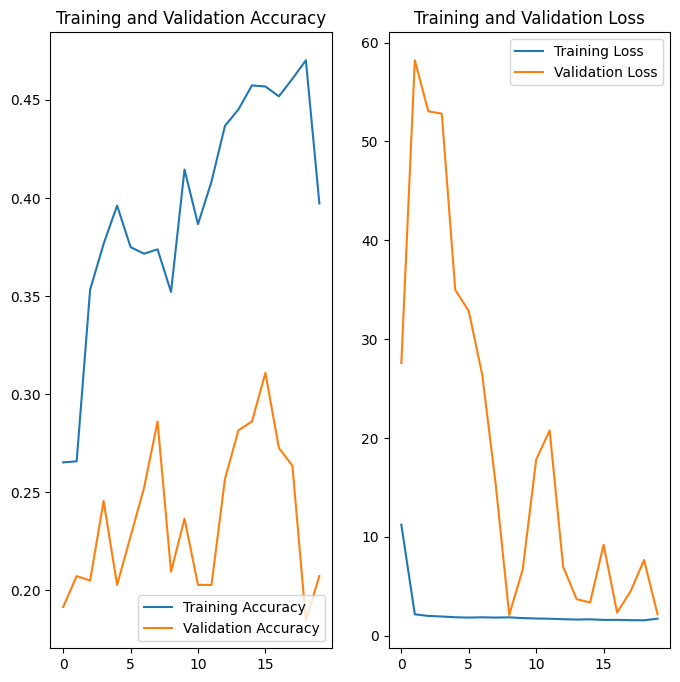

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## It can be seen that while the rate of overfitting reduced , testing accuracies have come down

In [30]:
tr_df

class  count    percent
0  pigmented benign keratosis    462  20.634212
1                    melanoma    438  19.562305
2        basal cell carcinoma    376  16.793211
3                       nevus    357  15.944618
4     squamous cell carcinoma    181   8.083966
5             vascular lesion    139   6.208129
6           actinic keratosis    114   5.091559
7              dermatofibroma     95   4.242966
8        seborrheic keratosis     77   3.439035

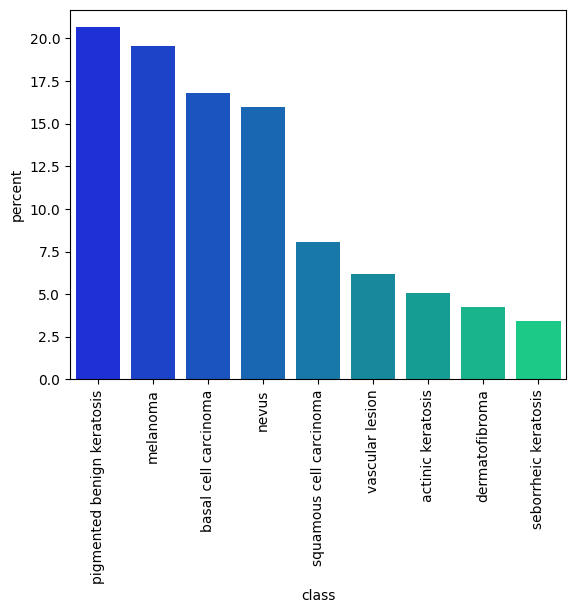

In [31]:

sns.barplot(data=tr_df,x='class',y='percent',palette='winter')
plt.xticks(rotation=90)
plt.show()


## It can be observed that the classes starting from squamous cell carcinoma have very few values
## Dealing with the imbalance here might increase accuracy
### Pigmened benign keratosis has the highest samples , while seborrheic keratosis has the least samples in the dataset

# Rectify Class Imbalance using the Augmentor Library


In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.
4. Probabilities Generated from Random Sampling - [0.4482309151022328,
 0.4331950210212008,
 0.5725267370185138,
 0.5529110994463282,
 0.28689121947332147]--> 2500 images


In [33]:
# Applying Augmentor
import Augmentor
import numpy as np
# p_rotate_norm = np.random.uniform(0.3,.65)
# p_skew = np.random.uniform(0.4,.7)
# p_flip = np.random.uniform(0.4,.6)
# p_rotate = np.random.uniform(0.3,.6)
# p_distortion = np.random.uniform(0.15,.5)
p_rotate_norm,p_skew,p_flip,p_rotate, p_distortion = [0.4482309151022328,
 0.4331950210212008,
 0.5725267370185138,
 0.5529110994463282,
 0.28689121947332147]
path_to_training_dataset = "/content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=p_rotate_norm, max_left_rotation=25, max_right_rotation=25)
    p.skew_corner(probability=p_skew)
    p.flip_left_right(probability=p_flip)
    # p.rotate_random_90(probability = p_rotate)
    p.random_distortion(probability = p_distortion,grid_width = 10,grid_height=10,magnitude=np.random.randint(5,9))
    p.sample(2500) ## We are adding 2500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E709DFC4280>: 100%|██████████| 2500/2500 [01:58<00:00, 21.06 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E709DF25B70>: 100%|██████████| 2500/2500 [01:37<00:00, 25.61 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E709DA1E4D0>: 100%|██████████| 2500/2500 [01:37<00:00, 25.72 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E711C136560>: 100%|██████████| 2500/2500 [09:12<00:00,  4.53 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E709D4EE4D0>: 100%|██████████| 2500/2500 [08:22<00:00,  4.97 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E709DF83910>: 100%|██████████| 2500/2500 [01:35<00:00, 26.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E709DFA6530>: 100%|██████████| 2500/2500 [03:59<00:00, 10.45 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E709DE93EE0>: 100%|██████████| 2500/2500 [01:38<00:00, 25.50 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E709DFA54E0>: 100%|██████████| 2500/2500 [01:35<00:00, 26.10 Samples/s]


In [34]:
[p_rotate_norm,
p_skew,
p_flip,
p_rotate,
p_distortion]

[0.4482309151022328,
 0.4331950210212008,
 0.5725267370185138,
 0.5529110994463282,
 0.28689121947332147]

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

22500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list= os.path.join(data_dir_train, '*','output', '*.jpg')
path_list_new[0]

'/content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001134.jpg_73f9945d-8b07-4dc5-90be-0306574cfe06.jpg'

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
np.unique(lesion_list_new)

array(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
       'melanoma', 'nevus', 'pigmented benign keratosis',
       'seborrheic keratosis', 'squamous cell carcinoma',
       'vascular lesion'], dtype='<U26')

In [38]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
# dataframe_dict_new

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','class'])
# new_df = original_df.append(df2)

In [40]:
df2  = df2['class'].value_counts().reset_index()
df2.columns = ['class','count']
# df2['percent'] = 100 * df['count'] / df['count'].sum()
df2

class  count
0                    melanoma   2500
1        basal cell carcinoma   2500
2             vascular lesion   2500
3        seborrheic keratosis   2500
4           actinic keratosis   2500
5  pigmented benign keratosis   2500
6                       nevus   2500
7              dermatofibroma   2500
8     squamous cell carcinoma   2500

In [41]:
tr_df = tr_df.drop('percent',axis=1)
tr_df = pd.concat([tr_df,df2],axis=0)
tr_df = tr_df.groupby(['class'])['count'].sum().reset_index()


In [42]:
tr_df['percent'] = 100 * tr_df['count'] / tr_df['count'].sum()
tr_df

class  count    percent
0           actinic keratosis   2614  10.566312
1        basal cell carcinoma   2876  11.625369
2              dermatofibroma   2595  10.489510
3                    melanoma   2938  11.875985
4                       nevus   2857  11.548567
5  pigmented benign keratosis   2962  11.972998
6        seborrheic keratosis   2577  10.416751
7     squamous cell carcinoma   2681  10.837140
8             vascular lesion   2639  10.667367

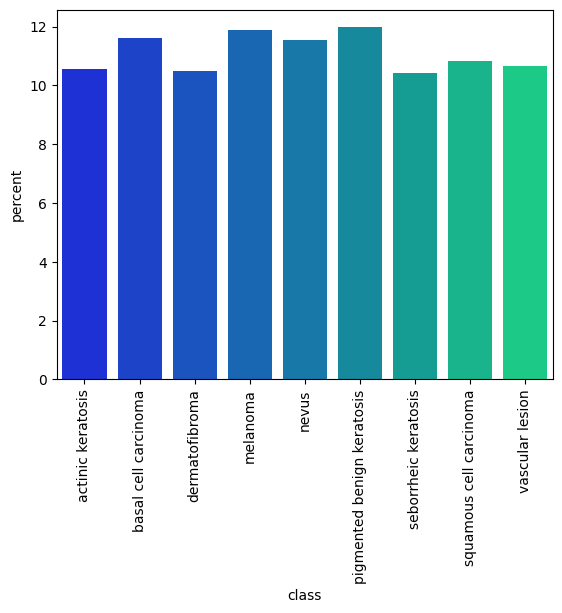

In [43]:

sns.barplot(data=tr_df,x='class',y='percent',palette='winter')
plt.xticks(rotation=90)
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [45]:
data_dir_train="/content/Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='both',)

Found 24739 files belonging to 9 classes.
Using 19792 files for training.
Using 4947 files for validation.


In [46]:
# User
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## With Dropouts - M1 (32-2x , 64-2x ,128 1x )

In [47]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    # layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 41, 41, 64)       

In [48]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
619/619 [==============================] - 120s 75ms/step - loss: 1.6577 - accuracy: 0.3423 - val_loss: 1.4249 - val_accuracy: 0.4221
Epoch 2/30
619/619 [==============================] - 26s 42ms/step - loss: 1.4217 - accuracy: 0.4378 - val_loss: 1.3246 - val_accuracy: 0.4651
Epoch 3/30
619/619 [==============================] - 27s 44ms/step - loss: 1.3235 - accuracy: 0.4790 - val_loss: 1.2440 - val_accuracy: 0.5098
Epoch 4/30
619/619 [==============================] - 25s 41ms/step - loss: 1.2385 - accuracy: 0.5147 - val_loss: 1.1629 - val_accuracy: 0.5381
Epoch 5/30
619/619 [==============================] - 25s 40ms/step - loss: 1.1605 - accuracy: 0.5525 - val_loss: 1.0579 - val_accuracy: 0.5917
Epoch 6/30
619/619 [==============================] - 25s 41ms/step - loss: 1.0992 - accuracy: 0.5748 - val_loss: 1.0623 - val_accuracy: 0.5884
Epoch 7/30
619/619 [==============================] - 25s 40ms/step - loss: 1.0088 - accuracy: 0.6134 - val_loss: 1.0010 - val_accuracy

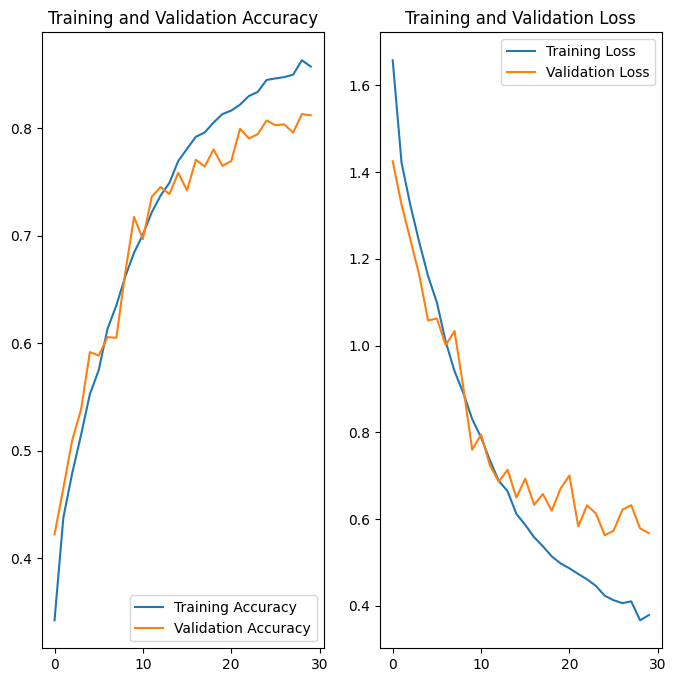

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## With Dropouts Model - M2 (8 -1x , 16 - 1x , 32- 1x,64 - 1x and 128-1x)




In [69]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Dropout(0.25),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.Dropout(0.4),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 178, 178, 8)       224       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 89, 89, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 87, 87, 16)        1168      
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 43, 43, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 41, 41, 32)      

In [70]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
619/619 [==============================] - 13s 18ms/step - loss: 1.6392 - accuracy: 0.3532 - val_loss: 1.6429 - val_accuracy: 0.3360
Epoch 2/40
619/619 [==============================] - 11s 17ms/step - loss: 1.3848 - accuracy: 0.4597 - val_loss: 1.2609 - val_accuracy: 0.5163
Epoch 3/40
619/619 [==============================] - 11s 17ms/step - loss: 1.2663 - accuracy: 0.5098 - val_loss: 1.2078 - val_accuracy: 0.5294
Epoch 4/40
619/619 [==============================] - 11s 17ms/step - loss: 1.1638 - accuracy: 0.5525 - val_loss: 1.0848 - val_accuracy: 0.5743
Epoch 5/40
619/619 [==============================] - 10s 17ms/step - loss: 1.0728 - accuracy: 0.5852 - val_loss: 1.0565 - val_accuracy: 0.6002
Epoch 6/40
619/619 [==============================] - 10s 17ms/step - loss: 1.0114 - accuracy: 0.6098 - val_loss: 0.9444 - val_accuracy: 0.6424
Epoch 7/40
619/619 [==============================] - 10s 17ms/step - loss: 0.9566 - accuracy: 0.6339 - val_loss: 0.8999 - val_accuracy:

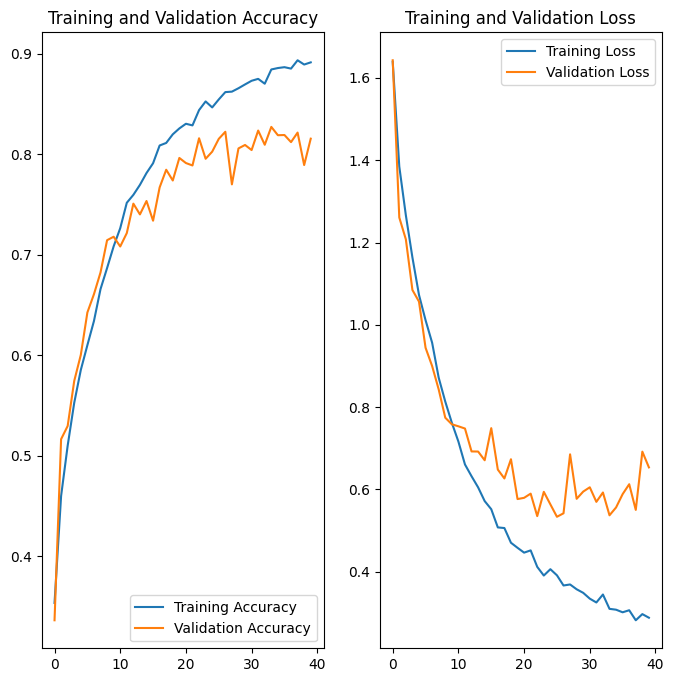

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## With Batch Normalization and Dropouts Model - M3 (8 -1x , 16 - 1x , 32- 1x,64 - 1x and 128-1x)

In [66]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Dropout(0.25),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
     layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.Dropout(0.4),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 178, 178, 8)       224       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 89, 89, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 87, 87, 16)        1168      
                                                                 
 batch_normalization_5 (Bat  (None, 87, 87, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 43, 43, 16)       

In [67]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
619/619 [==============================] - 15s 20ms/step - loss: 1.4628 - accuracy: 0.4549 - val_loss: 1.5479 - val_accuracy: 0.4103
Epoch 2/40
619/619 [==============================] - 12s 20ms/step - loss: 1.1388 - accuracy: 0.5606 - val_loss: 1.8599 - val_accuracy: 0.4492
Epoch 3/40
619/619 [==============================] - 12s 20ms/step - loss: 0.9997 - accuracy: 0.6159 - val_loss: 1.4415 - val_accuracy: 0.4821
Epoch 4/40
619/619 [==============================] - 12s 20ms/step - loss: 0.9013 - accuracy: 0.6532 - val_loss: 1.5210 - val_accuracy: 0.4779
Epoch 5/40
619/619 [==============================] - 12s 20ms/step - loss: 0.8023 - accuracy: 0.6946 - val_loss: 0.8605 - val_accuracy: 0.6851
Epoch 6/40
619/619 [==============================] - 12s 19ms/step - loss: 0.7390 - accuracy: 0.7180 - val_loss: 1.3064 - val_accuracy: 0.5832
Epoch 7/40
619/619 [==============================] - 12s 20ms/step - loss: 0.6741 - accuracy: 0.7408 - val_loss: 0.9247 - val_accuracy:

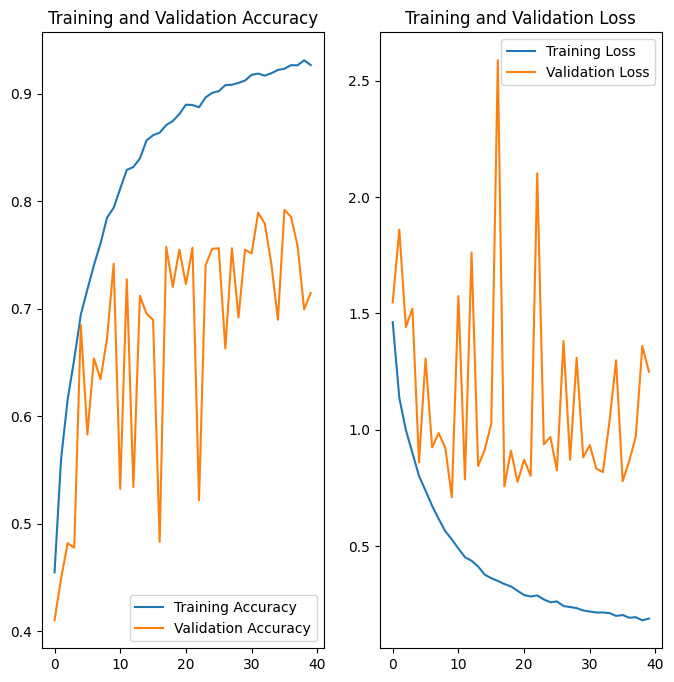

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## With Batch Normalization or Dropouts - M4

In [53]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Conv2D(8, (3, 3), activation='relu'),


    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.Dropout(0.23),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.23),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.23),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.MaxPooling2D((2, 2)),
    # layers.BatchNormalization(),
    # layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.Dropout(0.4),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 178, 178, 8)       224       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 89, 89, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 87, 87, 16)        1168      
                                                                 
 dropout_5 (Dropout)         (None, 87, 87, 16)        0         
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 43, 43, 16)        0         
 ng2D)                                                

In [54]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
619/619 [==============================] - 13s 18ms/step - loss: 1.5988 - accuracy: 0.3664 - val_loss: 1.5170 - val_accuracy: 0.4320
Epoch 2/50
619/619 [==============================] - 11s 18ms/step - loss: 1.3686 - accuracy: 0.4628 - val_loss: 1.3924 - val_accuracy: 0.4894
Epoch 3/50
619/619 [==============================] - 11s 18ms/step - loss: 1.2459 - accuracy: 0.5169 - val_loss: 1.2909 - val_accuracy: 0.5316
Epoch 4/50
619/619 [==============================] - 11s 18ms/step - loss: 1.1464 - accuracy: 0.5542 - val_loss: 1.2880 - val_accuracy: 0.4973
Epoch 5/50
619/619 [==============================] - 11s 18ms/step - loss: 1.0309 - accuracy: 0.6064 - val_loss: 1.1598 - val_accuracy: 0.5680
Epoch 6/50
619/619 [==============================] - 11s 18ms/step - loss: 0.9389 - accuracy: 0.6413 - val_loss: 1.1157 - val_accuracy: 0.5781
Epoch 7/50
619/619 [==============================] - 11s 18ms/step - loss: 0.8456 - accuracy: 0.6744 - val_loss: 1.0644 - val_accuracy:

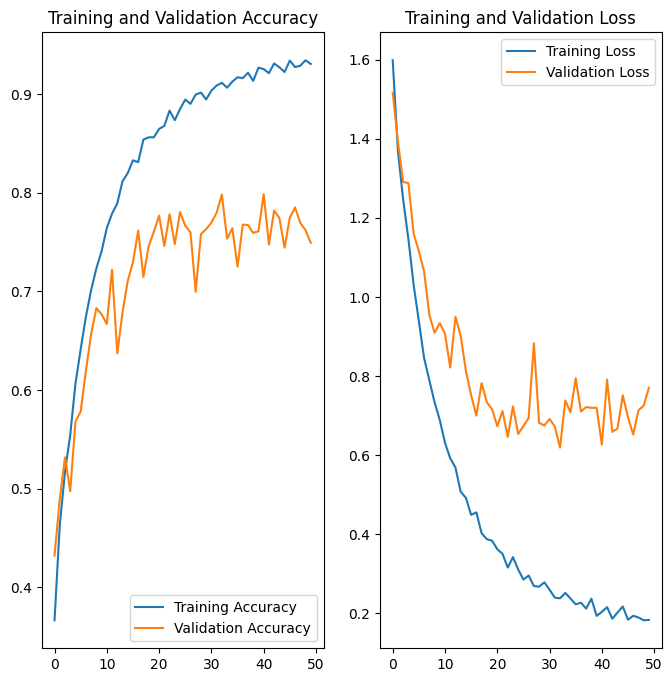

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [76]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (4, 4), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (4,4 ), activation='relu'),
    #  layers.BatchNormalization(),
    # layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (4, 4), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (4, 4), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 173, 173, 32)      6176      
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 86, 86, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_67 (Conv2D)          (None, 79, 79, 32)        65568     
                                                                 
 max_pooling2d_71 (MaxPooli  (None, 39, 39, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_68 (Conv2D)          (None, 32, 32, 64)      

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
619/619 [==============================] - 36s 51ms/step - loss: 2.2016 - accuracy: 0.1156 - val_loss: 2.1962 - val_accuracy: 0.1170
Epoch 2/40
619/619 [==============================] - 30s 48ms/step - loss: 2.1962 - accuracy: 0.1180 - val_loss: 2.1961 - val_accuracy: 0.1199
Epoch 3/40
619/619 [==============================] - 29s 48ms/step - loss: 2.1961 - accuracy: 0.1166 - val_loss: 2.1964 - val_accuracy: 0.1199
Epoch 4/40
619/619 [==============================] - 30s 48ms/step - loss: 2.1961 - accuracy: 0.1140 - val_loss: 2.1962 - val_accuracy: 0.1199
Epoch 5/40
619/619 [==============================] - 30s 48ms/step - loss: 2.1961 - accuracy: 0.1181 - val_loss: 2.1962 - val_accuracy: 0.1199
Epoch 6/40
619/619 [==============================] - 30s 48ms/step - loss: 2.1961 - accuracy: 0.1182 - val_loss: 2.1962 - val_accuracy: 0.1170
Epoch 7/40
619/619 [==============================] - 30s 48ms/step - loss: 2.1960 - accuracy: 0.1172 - val_loss: 2.1963 - val_accuracy:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()